# Brazilian E-Commerce Public Dataset - RFM

#### **Dados analisados retirados em:**

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?resource=download


#### **Equipe:**

Lívia Nobre;

Májda Alvarenga

# Introdução

Este é um conjunto de dados público de comércio eletrônico brasileiro de pedidos realizados na loja Olist.

O conjunto de dados contém informações sobre 100 mil pedidos realizados entre 2016 e 2018 em diversos marketplaces no Brasil. As suas características permitem visualizar um pedido sob múltiplas dimensões: desde o status do pedido, preço, pagamento e desempenho do frete, até a localização do cliente, atributos do produto e, finalmente, as avaliações escritas pelos clientes. Também é possível usar os dados de geolocalização que relaciona os CEPs brasileiros às coordenadas lat/lng.

# Objetivo

Esse código realiza uma análise detalhada dos clientes, segmentando-os em clusters com base em suas características de recência, frequência e valor monetário.

A segmentação é feita utilizando KMeans e PCA, além de visualizações detalhadas para compreender a distribuição e o comportamento de cada cluster.



In [ ]:
!pip install kneed
!pip install pypalettes

# Bibliotecas padrão
import os
import requests

# Bibliotecas para manipulação de dados
import numpy as np
import pandas as pd

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pypalettes import get_hex

# Bibliotecas para modelagem e pré-processamento
from kneed import KneeLocator

# Modelos
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Função de categorização de quartis:

  A função categorize_quartiles é usada para classificar um valor em um dos quatro quartis, com base em uma lista de quartis.


In [ ]:
def categorize_quartiles(value, quartiles):
    if value <= quartiles[0]:
        return 4
    elif value <= quartiles[1]:
        return 3
    elif value <= quartiles[2]:
        return 2
    else:
        return 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##Leitura dos dados:

In [ ]:
df_orders = pd.read_csv('/content/olist_orders_dataset.csv')
df_order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
df_products = pd.read_csv('/content/olist_products_dataset.csv')
df_customers = pd.read_csv('/content/olist_customers_dataset.csv')
df_payments = pd.read_csv('/content/olist_order_payments_dataset.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = pd.merge(df_orders, df_order_items, on='order_id', how='inner')
df = pd.merge(df, df_customers, on='customer_id', how='inner')
df = pd.merge(df, df_payments, on='order_id', how='left')
df = pd.merge(df, df_products, on='product_id', how='left')
df['total_price'] = df['price'] + df['freight_value']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,total_price
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,18.12,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,38.71
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,2.00,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,38.71
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,...,18.59,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,38.71
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,...,141.46,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,...,179.12,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0,179.12


##Cálculo de métricas RFM e atribuição dos quartis:

**Recência (R):** A quantidade de dias desde que o pedido foi aprovado.

**Frequência (F):** O número de pedidos feitos por um cliente.

**Monetário (M):** O total gasto por cada cliente.


In [ ]:

df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_approved_at'].max()
df['dd_approved'] = (df['order_approved_at'].max() - df['order_approved_at']).dt.days
df_R = df.groupby('customer_id')['dd_approved'].min().reset_index()
df_R = df_R.fillna(100)
df_F = df['customer_id'].value_counts().to_frame().reset_index()
df_M = df.groupby('customer_id')['payment_value'].sum().reset_index()

RFM = pd.merge(df_R, df_F, on='customer_id', how='inner')
RFM = pd.merge(RFM, df_M, on='customer_id', how='inner')

RFM.columns = ['customer_id','rec','freq','mon']
RFM_R = RFM[['customer_id','rec']].sort_values(by='rec')
RFM_F = RFM[['customer_id','freq']].sort_values(by='freq')
RFM_M = RFM[['customer_id','mon']].sort_values(by='mon')

# Atribuição dos quartis
quartiles = np.percentile(RFM_R['rec'], [25, 50, 75])
RFM_R['R'] = RFM_R['rec'].apply(categorize_quartiles, args=(quartiles,))

quartiles = np.percentile(RFM_F['freq'], [25, 50, 75])
RFM_F['F'] = RFM_F['freq'].apply(categorize_quartiles, args=(quartiles,))

quartiles = np.percentile(RFM_M['mon'], [25, 50, 75])
RFM_M['M'] = RFM_M['mon'].apply(categorize_quartiles, args=(quartiles,))

RFM = pd.merge(RFM_R, RFM_F, on='customer_id', how='inner')
RFM = pd.merge(RFM, RFM_M, on='customer_id', how='inner')

RFM = RFM[['customer_id','rec','freq','mon','R','F','M']]
RFM['FM'] = np.round((RFM['F'] + RFM['M'])/2)
RFM['FM'] = RFM['FM'].astype(int)

print(RFM)
print(RFM.columns)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                            customer_id    rec  freq     mon  R  F  M  FM
0      4b7decb9b58e2569548b8b4c8e20e8d7    0.0     1  166.46  4  4  2   3
1      478778636c75019554439f75286a22e3    5.0     1  161.97  4  4  2   3
2      004440537b68545ca3c341d7279bc4c0    5.0     2  196.08  4  1  1   1
3      b8c19e70d00f6927388e4f31c923d785    5.0     1  178.25  4  4  2   3
4      e450a297a7bc6839ceb0cf1a2377fa02    5.0     1   73.10  4  4  3   4
...                                 ...    ...   ...     ... .. .. ..  ..
98661  16e14c1e6e050fe6730c961ff638ca23  699.0     7   86.88  1  1  3   2
98662  aadd27185177fc7ac9b364898ac09343  699.0     2  202.88  1  1  1   1
98663  e9722ab28655e07763e0ca2751c61c90  699.0     1  214.98  1  4  1   2
98664  f9808148a262b51d20e2d777eee6676c  699.0     1  319.00  1  4  1   2
98665  86dc2ffce2dfff336de2f386a786e574  718.0     3    0.00  1  1  4   2

[98666 rows x 8 columns]
Index(['customer_id', 'rec', 'freq', 'mon', 'R', 'F', 'M', 'FM'], dtype='object')


##Visualização dos dados:

  São gerados boxplots para visualizar a distribuição das variáveis rec, freq e mon, de forma a entender melhor os dados e identificar outliers.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


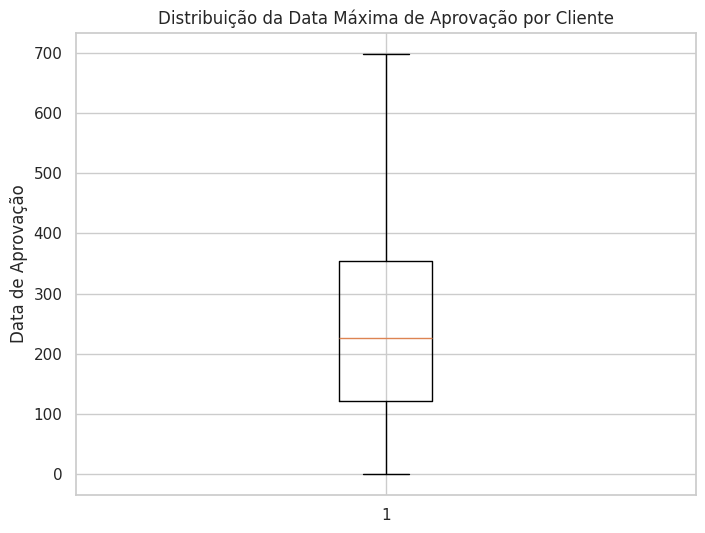

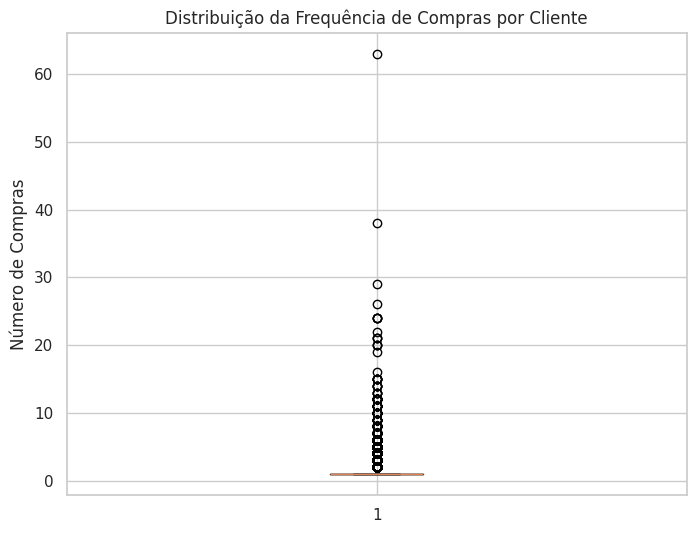

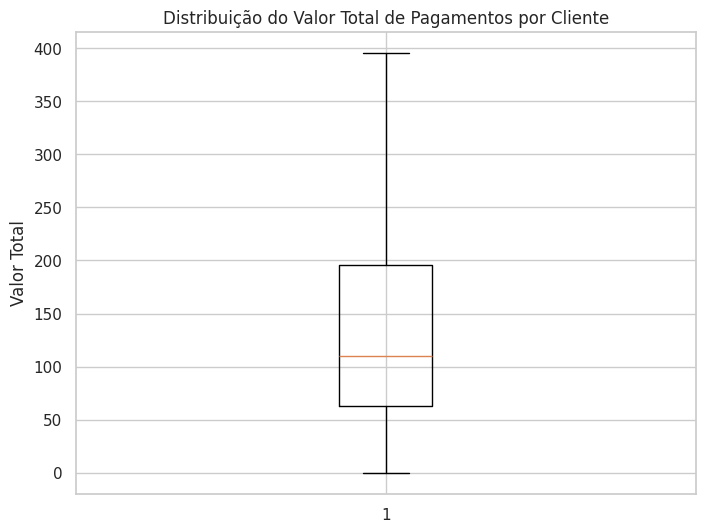

In [ ]:
# Boxplot para df_R
plt.figure(figsize=(8, 6))
plt.boxplot(RFM['rec'], showfliers=False)
plt.title('Distribuição da Data Máxima de Aprovação por Cliente')
plt.ylabel('Data de Aprovação')
plt.show()

# Boxplot para df_F
plt.figure(figsize=(8, 6))
plt.boxplot(RFM['freq'], showfliers=True)
plt.title('Distribuição da Frequência de Compras por Cliente')
plt.ylabel('Número de Compras')
plt.show()

# Boxplot para df_M
plt.figure(figsize=(8, 6))
plt.boxplot(RFM['mon'], showfliers=False)
plt.title('Distribuição do Valor Total de Pagamentos por Cliente')
plt.ylabel('Valor Total')
plt.show()

##Método Elbow para determinar o número de clusters:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


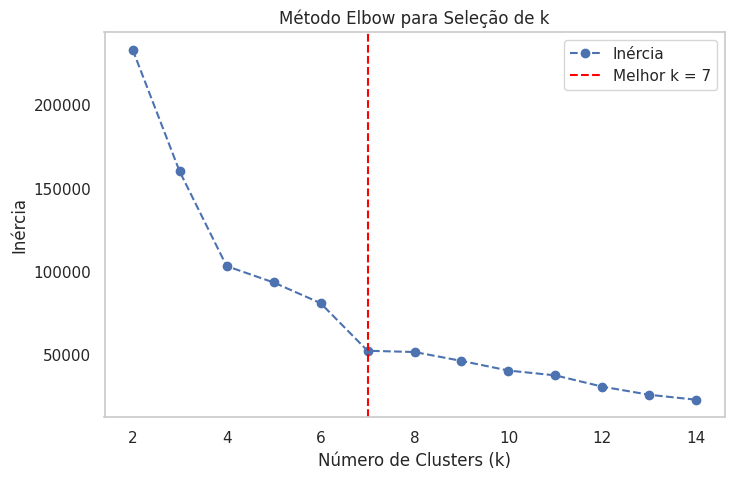

In [ ]:
wcss = []

min_cluster = 1
max_cluster = 10

RFM_elbow = RFM[['R','F','M']]
vet_k = range(2,15)

for k in vet_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(RFM_elbow)
    wcss.append(kmeans.inertia_)

# Determinando o melhor número de clusters usando o método Elbow
knee_locator = KneeLocator(vet_k, wcss, curve="convex", direction="decreasing")
best_k = knee_locator.knee

# Plotando o gráfico de Elbow com a indicação do melhor número de clusters
plt.figure(figsize=(8, 5))
plt.plot(vet_k, wcss, marker='o', linestyle='--', label='Inércia')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Melhor k = {best_k}')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método Elbow para Seleção de k')
plt.legend()
plt.grid()
plt.show()
plt.show()

##Normalização, PCA e visualização dos Clusters:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


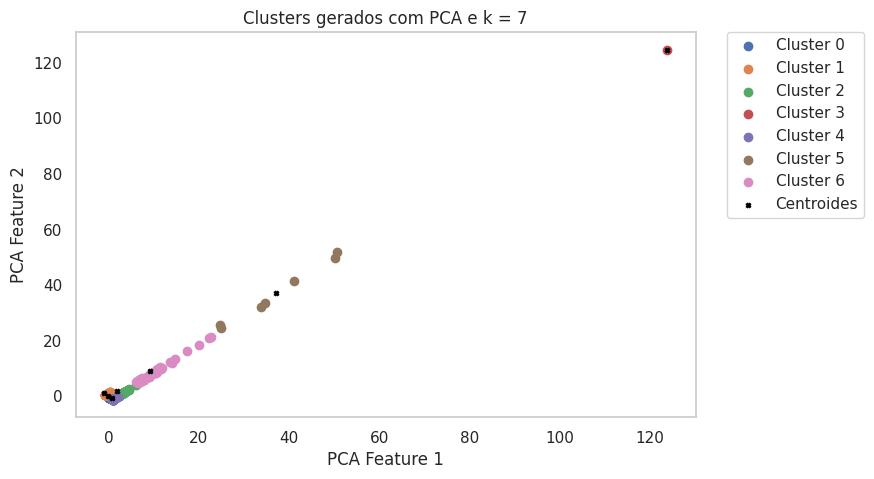

In [ ]:
# Passo 1: Normalizar os dados
scaler = StandardScaler()
normalized_data = scaler.fit_transform(RFM[['rec','mon']])

# Passo 2: Aplicar PCA para reduzir para 2 dimensões
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

# Convertendo de volta para um DataFrame para visualização
df_pca = pd.DataFrame(pca_data, columns=['PCA_Feature_1', 'PCA_Feature_2'])

# Passo 3: Gerar clusters usando K-Means com k = 7
k = 7
kmeans_pca = KMeans(n_clusters=k, random_state=42)
df_pca['Cluster'] = kmeans_pca.fit_predict(df_pca)

# Passo 4: Visualizar os clusters gerados
plt.figure(figsize=(8, 5))
for cluster in range(k):
    clustered_data = df_pca[df_pca['Cluster'] == cluster].iloc[0:50]
    plt.scatter(clustered_data['PCA_Feature_1'], clustered_data['PCA_Feature_2'], label=f'Cluster {cluster}')

# Marcando os centroides
centroids_pca = kmeans_pca.cluster_centers_
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=10, c='black', marker='X', label='Centroides')


plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Clusters gerados com PCA e k = 7')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


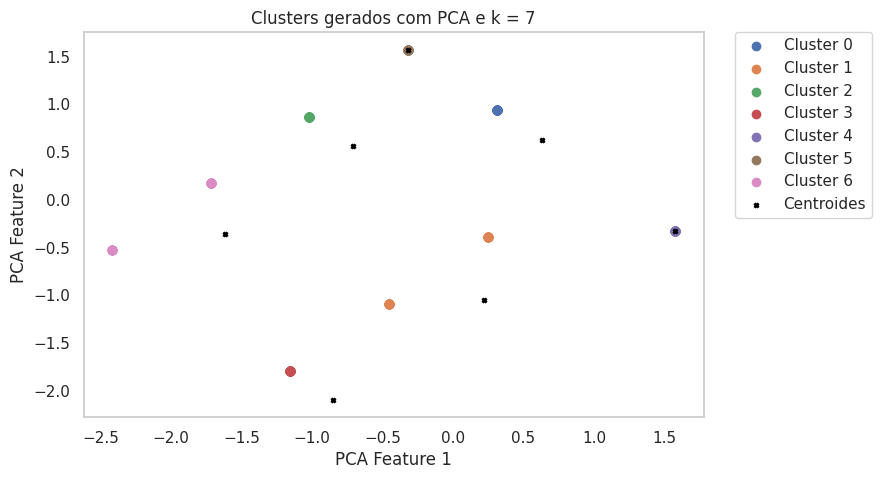

In [ ]:
# Passo 1: Normalizar os dados
scaler = StandardScaler()
normalized_data = scaler.fit_transform(RFM[['R','FM']])

# Passo 2: Aplicar PCA para reduzir para 2 dimensões
pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

# Convertendo de volta para um DataFrame para visualização
df_pca = pd.DataFrame(pca_data, columns=['PCA_Feature_1', 'PCA_Feature_2'])

# Passo 3: Gerar clusters usando K-Means com k = 7
k = 7
kmeans_pca = KMeans(n_clusters=k, random_state=42)
df_pca['Cluster'] = kmeans_pca.fit_predict(df_pca)
RFM['Cluster'] = df_pca['Cluster']

# Passo 4: Visualizar os clusters gerados
plt.figure(figsize=(8, 5))
for cluster in range(k):
    clustered_data = df_pca[df_pca['Cluster'] == cluster].iloc[0:50]
    plt.scatter(clustered_data['PCA_Feature_1'], clustered_data['PCA_Feature_2'], label=f'Cluster {cluster}')

# Marcando os centroides
centroids_pca = kmeans_pca.cluster_centers_
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=10, c='black', marker='X', label='Centroides')

plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('Clusters gerados com PCA e k = 7')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [ ]:
RFM['Cluster'].value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
Cluster,
0,23760
1,21015
6,14185
4,12012
2,11742
5,11701
3,4251


##Boxplots dos clusters:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pypalettes/deprecated.py:71: DeprecationWarning: 
The get_hex() function is deprecated and will be removed in a future version.
Please, use: load_cmap('plasma').hex

  warnings.warn(warning_message, category=DeprecationWarning)
<ipython-input-32-b56081458a94>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y='rec', showfliers=False, palette=palette)


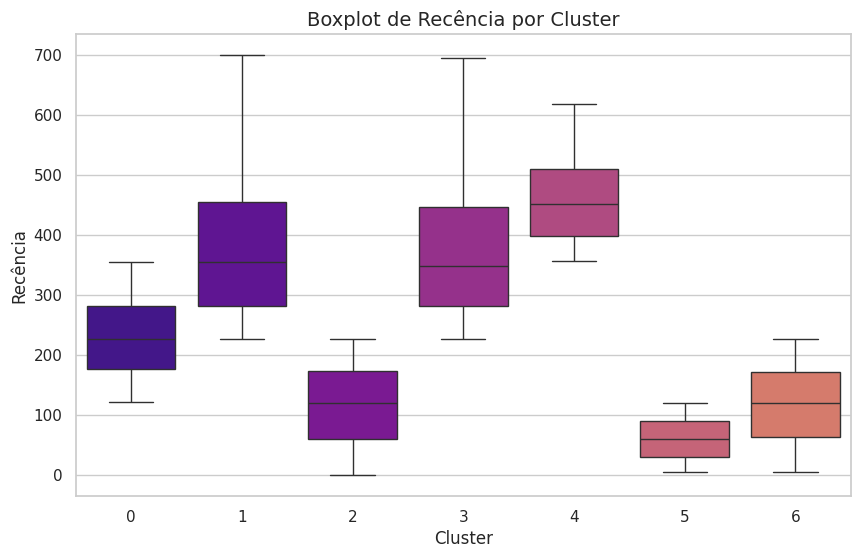

<ipython-input-32-b56081458a94>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y='freq', showfliers=False, palette=palette)


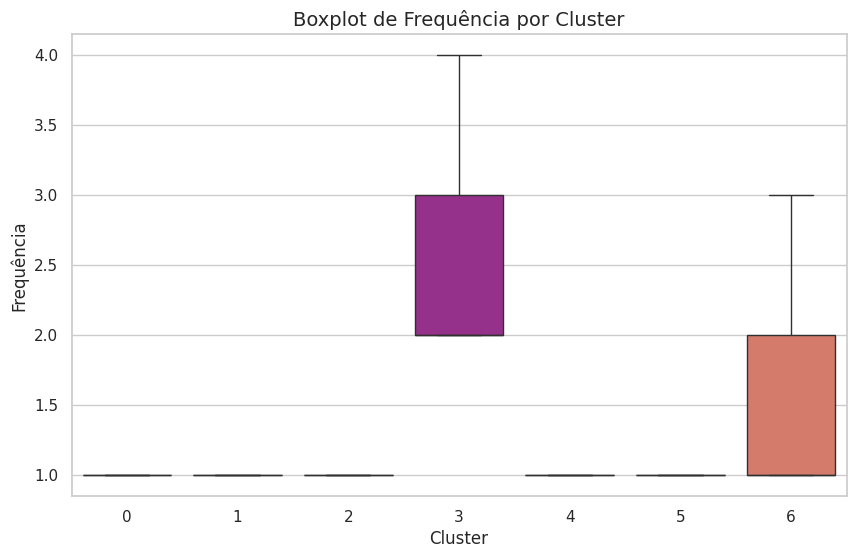

<ipython-input-32-b56081458a94>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Cluster', y='mon', showfliers=False, palette=palette)


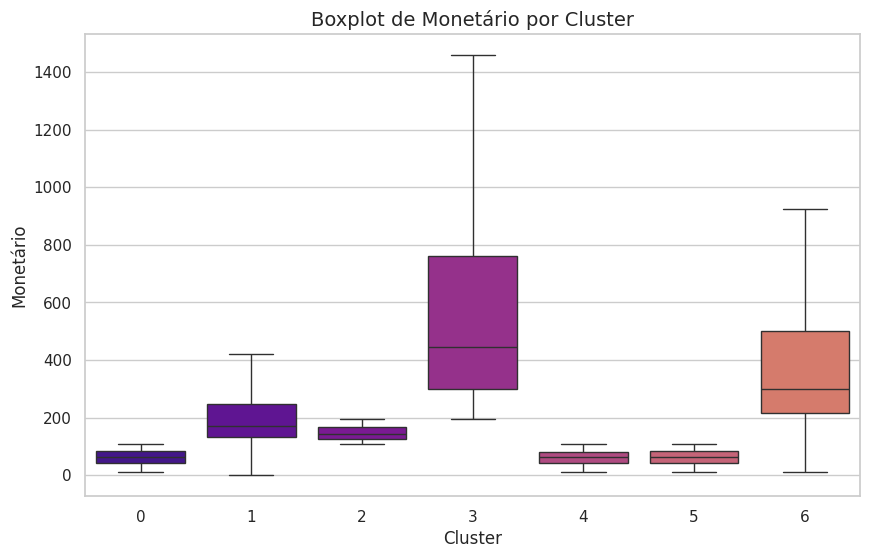

In [ ]:


# Configurar o estilo do Seaborn
sns.set(style="whitegrid")
df = RFM

palette = get_hex("plasma", keep_first_n=7)

# Criar o boxplot para a coluna 'rec'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='rec', showfliers=False, palette=palette)
plt.title('Boxplot de Recência por Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Recência', fontsize=12)
plt.show()

# Criar o boxplot para a coluna 'freq'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='freq', showfliers=False, palette=palette)
plt.title('Boxplot de Frequência por Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.show()

# Criar o boxplot para a coluna 'mon'
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Cluster', y='mon', showfliers=False, palette=palette)
plt.title('Boxplot de Monetário por Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Monetário', fontsize=12)
plt.show()

##Cálculo de um "score":

In [ ]:
RFM['Score'] = (RFM['F'] + RFM['M'])
RFM['Score'] = RFM['Score'] / RFM['Score'].max()
RFM['Score'] = RFM['Score'] * 10
RFM['Media_F_M'] = (RFM['F'] + RFM['M']) / 2
RFM[['Cluster','Score','F','M','Media_F_M','R']].value_counts().sort_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster  Score  F  M  Media_F_M  R
0        8.75   4  3  3.5        2    6094
                                 3    5819
         10.00  4  4  4.0        2    5839
                                 3    6008
1        3.75   1  2  1.5        1     614
                                 2     506
         5.00   1  3  2.0        1     315
                                 2     258
         6.25   1  4  2.5        1     244
                                 2     213
                4  1  2.5        1    4014
                                 2    3982
         7.50   4  2  3.0        1    5269
                                 2    5600
2        7.50   4  2  3.0        3    5775
                                 4    5967
3        2.50   1  1  1.0        1    2036
                                 2    2215
4        8.75   4  3  3.5        1    5936
         10.00  4  4  4.0        1    6076
5        8.75   4  3  3.5        4    5758
         10.00  4  4  4.0        4    5943
6        2.50   1  1  1.0        3    2154
                                 4    2142
         3.75   1  2  1.5        3     493
                                 4     442
         5.00   1  3  2.0        3     237
                                 4     249
         6.25   1  4  2.5        3     181
                                 4     165
                4  1  2.5        3    3968
                                 4    4154
Name: count, dtype: int64

# Análise de resultados

Segundo o artigo no site Medium, podemos classificar os clientes em diversas categorias:




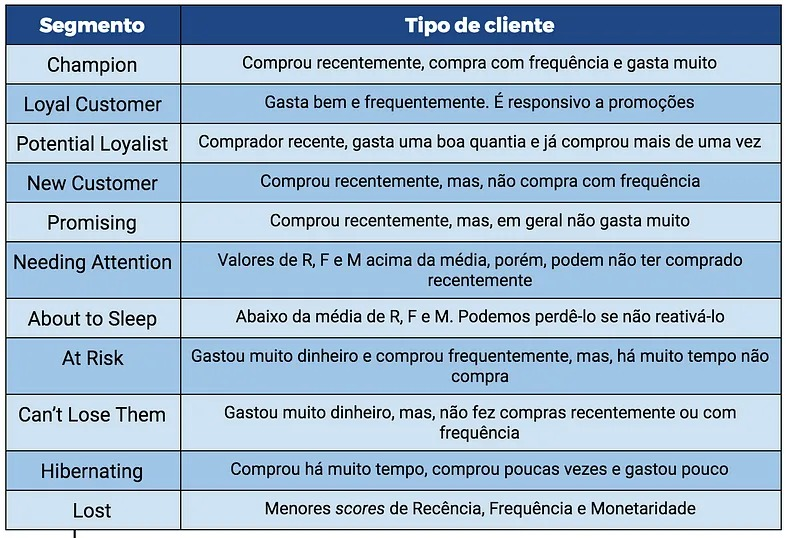

Analisando os dados obtidos com os boxplot, podemos definir:

**Classe 0: About to sleep:** Frequência baixa, valor monetário mediano e tempo médio de recência.

**Classe 1: Lost:** Frequência baixa, valor monetário baixo e tempo alto de recência.

**Classe 2: Promising:** Frequência baixa, valor monetário mediano e tempo baixo de recência.

**Classe 3: At Risk:** Frequência alta, valor monetário alto e tempo alto de recência.

**Classe 4: Hibernating:** Frequência baixa, valor monetário baixo e tempo alto de recência.

**Classe 5: New Custumer:**Frequência baixa, valor monetário baixo e tempo baixo de recência.

**Classe 6: Potencial Loyalist** Frequência média, valor monetário alto e tempo médio de recência.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cluster
0          23760
1          21015
2          11742
3           4251
4          12012
5          11701
6          14185
Name: count, dtype: int64


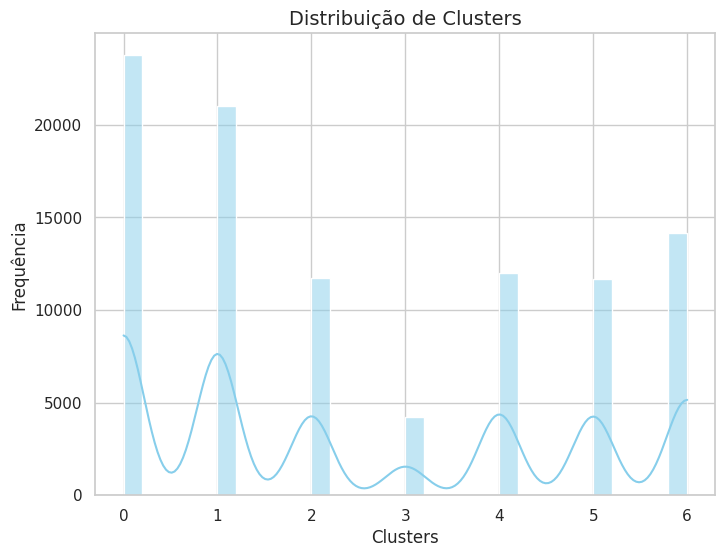

In [ ]:
# Definindo a cor 'bluesky' caso não tenha sido definida
bluesky = "#87CEEB"


# Contagem dos clusters
print(RFM[['Cluster']].value_counts().sort_index())

# Criando o gráfico (aqui, usamos apenas um gráfico como exemplo)
fig, ax = plt.subplots(figsize=(8, 6))

# Plotando o histograma com a curva KDE
sns.histplot(RFM['Cluster'], kde=True, color=bluesky, bins=30, ax=ax)

# Ajustando o título e os rótulos
ax.set_title('Distribuição de Clusters', fontsize=14)
ax.set_xlabel('Clusters')
ax.set_ylabel('Frequência')

# Exibindo o gráfico
plt.show()

# Análise dos Clientes por Cluster:

**Clientes dos clusters 0 e 1:** São os clientes com o menor valor para o negócio, mas, paradoxalmente, os mais numerosos. Isso sugere que, embora representem uma grande parte da base de clientes, o impacto financeiro de suas compras é limitado.

**Cliente do cluster 3:** Este grupo é o que apresenta maior frequência de compras e o maior valor monetário por cliente, o que indica um potencial significativo para o negócio. No entanto, é também o cluster com o menor número de clientes, o que torna esse segmento mais exclusivo, mas também mais difícil de atingir em termos de volume.

**Clientes dos clusters 2, 4, 5 e 6:** Esses clusters têm uma distribuição de clientes mais equilibrada, com números de clientes próximos entre si, mas com valores financeiros e comportamentais variados.

## Ações Sugeridas:

**Prioridade de ação:** Focar em reconquistar os clientes do cluster 3, visto que eles têm o maior potencial financeiro. São clientes com alta frequência de compras, e ações para fidelizá-los podem gerar um retorno significativo.

**Atração de clientes dos clusters 0 e 1:** Para os clusters 0 e 1, é importante desenvolver estratégias que atraiam esses clientes para um comportamento mais rentável. A chave será reduzir a recência das compras e aumentar a frequência de compra desses clientes, de modo que eles possam evoluir para um status mais promissor e com maior valor para o negócio.





Fonte: https://medium.com/maxmilhas-tech/o-que-%C3%A9-rfm-e-como-aplic%C3%A1-lo-ao-seu-time-de-customer-service-b9c35817ed01#:~:text=RFM%20%C3%A9%20a%20jun%C3%A7%C3%A3o%20de,a%20uma%20campanha%20de%20Marketing?